In [1]:
# Import libraries

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, assemble, transpile
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit import IBMQ, Aer
from qiskit.quantum_info import Statevector, partial_trace, random_unitary
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from numpy.random import randint, rand
from IPython.display import clear_output
from qiskit.extensions import Initialize
from statistics import mean, stdev, variance
from qiskit.providers.aer.noise import NoiseModel, device
from qiskit.providers.aer import QasmSimulator
import qiskit
from qiskit.test.ibmq_mock import mock_get_backend
from mitiq import zne
import matplotlib.pyplot as plt
import numpy as np
from math import pi, sqrt
import time
from random import choice, sample
IBMQ.save_account('bdde1c124342f5707b2cb22a03b9facf9d5ec281af7160895d0c1bc976438f056becb5a303f7adbf320d11f09e5e7512d7885c1a09c5df9f34804f09e7a49527',overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
shots = 1024
sim = provider.get_backend('ibmq_qasm_simulator')
backend = provider.get_backend('ibmq_lima')
state_vector_sim = Aer.get_backend('statevector_simulator')

<ipython-input-1-0865366a41b2>:7: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter


In [2]:
#Building Noise Model
backend = provider.get_backend('ibmq_lima')

# Build noise model from backend properties
noise_model = NoiseModel.from_backend(backend)
# Get coupling map from backend
coupling_map = backend.configuration().coupling_map
# Get basis gates from noise model
basis_gates = noise_model.basis_gates

actualbackend_properties = backend.properties()
readout_errors = device.basic_device_readout_errors(actualbackend_properties)
gate_errors = device.basic_device_gate_errors(actualbackend_properties)
error_values = device.readout_error_values(actualbackend_properties)
gate_param_values = device.gate_param_values(actualbackend_properties)
gate_error_values = device.gate_error_values(actualbackend_properties)
gate_length_values = device.gate_length_values(actualbackend_properties)
thermal_relaxation_values = device.thermal_relaxation_values(actualbackend_properties)

created_noise_model = NoiseModel()
for qubit, error in readout_errors:
    created_noise_model.add_readout_error(error, qubit)
for instr, qubit, error in gate_errors:
    created_noise_model.add_quantum_error(error, instr, qubit)
created_noisy_sim = QasmSimulator(noise_model = created_noise_model)

C:\Users\sriji\AppData\Roaming\Python\Python39\site-packages\qiskit\providers\aer\noise\device\models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (74584.65358595 > 2 * 33538.850265373534). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
C:\Users\sriji\AppData\Roaming\Python\Python39\site-packages\qiskit\providers\aer\noise\device\models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (74584.65358595 > 2 * 33538.850265373534). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
C:\Users\sriji\AppData\Roaming\Python\Python39\site-packages\qiskit\providers\aer\noise\device\models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (74584.65358595 > 2 * 335

In [3]:
def mitigate_error(circuit, message, shots):
    
    qr=QuantumRegister(1)
    meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
    #calbiration matrix
    t_qc = transpile(meas_calibs, state_vector_sim)
    qobj = assemble(t_qc, shots=10000)
    cal_results = state_vector_sim.run(qobj, noise_model=created_noise_model, shots=10000).result()
    meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
    meas_filter = meas_fitter.filter
    
    # Define the lambda values to use in ZNE
    lambda_values = list(range(1, 7, 2))

    # Create an empty list to store the expected values for each lambda value
    expected_values = []

    # Loop over each lambda value and perform ZNE
    for lambda_val in lambda_values:
        # Create a new quantum circuit for ZNE
        qr = QuantumRegister(circuit.num_qubits)
        cr = ClassicalRegister(1)
        qc_zne = QuantumCircuit(qr, cr)

        # Append the original circuit to the ZNE circuit
        qc_zne.append(circuit, qr, cr)

        # Determine the number of additional layers to add to the circuit
        d = qc_zne.depth()
        k = int(d * (lambda_val - 1) / 2)
        n = int(k / d)
        s = k % d

        # Add the additional layers to the circuit
        for i in range(n):
            qc_zne.append(circuit.inverse(), qr, cr)
            qc_zne.barrier()
            qc_zne.append(circuit, qr, cr)
            qc_zne.barrier()
        if s > 0:
            qc_zne.append(circuit.inverse(), qr, cr)
            qc_zne.barrier()
            qc_zne.append(circuit, qr, cr)
            qc_zne.barrier()
            for i in range(s - 1):
                qc_zne.append(circuit.inverse(), qr, cr)
                qc_zne.barrier()
                qc_zne.append(circuit, qr, cr)
                qc_zne.barrier()

        # Measure the last qubit in the ZNE circuit
        qc_zne.measure(qr[-1], cr)

        # Run the ZNE circuit on a simulator
        job = execute(qc_zne, backend=created_noisy_sim, shots=shots)
        results = job.result()
        
        mitigated_result=meas_filter.apply(results)
        mitigated_counts=mitigated_result.get_counts()

        # Calculate the expected value for the message
        expected_value=mitigated_counts[str(message)]/shots

        # Add the expected value to the list
        expected_values.append(expected_value)

    # Fit a quadratic curve to the expected values
    coeffs = np.polyfit(lambda_values, expected_values, 2)

    # Use the quadratic curve to estimate the expected value for lambda=0
    expected_value_0 = coeffs[-1]

    # If the estimated expected value is outside of [0,1], clip it to [0,1]
    if expected_value_0 < 0:
        expected_value_0 = 0
    elif expected_value_0 > 1:
        expected_value_0 = 1

    # Calculate the final count for the message
    final_count = round(expected_value_0 * shots)

    # Return a dictionary with the final counts for the message and its complement
    if (message == 0):
        return {'0': final_count, '1': shots - final_count}
    else:
        return {'0': shots - final_count, '1': final_count}

In [4]:
#function to create pure entangled states

def pure_estate(circuit,q0,q1):
    u1 = random_unitary(2)
    circuit.append(u1,[q0])
    circuit.cx(q0,q1)
    
    return circuit       

In [5]:
###### Generating a random message

n=int(input("Length of message:"))
message = np.random.randint(2, size = n)
print(message)
nd=int(input("Number of decoy bits to be inserted:"))

Length of message:15
[1 1 1 0 1 1 0 0 1 1 1 1 1 0 0]
Number of decoy bits to be inserted:10


In [6]:
#Generating a list of possible states

states=['0', '1', '+', '-']

In [7]:
#Generating set of decoy photons

dq_st=[]
def gen_decoy(i):
    dqu=QuantumCircuit(1,1)
    if i=='1' or i=='-':
        dqu.x(0)
    if i=='+' or i=='-':
        dqu.h(0)
    return dqu
    #dqu.save_statevetor()
    #dq.append(dqu)
    #result = state_vector_sim.run(dqu).result()
    #sv = result.get_statevector()
    #dq_st.append(sv)

In [8]:
#Step1:Creating n pure entangled states
def create_pest(m):
    pk=[]
    for i in range(m):
        qr = QuantumRegister(2, 'qb')
        cr = ClassicalRegister(1, 'cb')
        circuit = QuantumCircuit(qr,cr)
        state=(pure_estate(circuit,qr[0],qr[1]))
        pk.append(state)
        #display(pk[i].draw('mpl'))
    return pk

private_key0=create_pest(n)
#check eavesdropping by adding decoy photons at random position and printing the positions

def create_pkd(private_key,n,nd):
    pkd=[]
    for i in range(n):
        pkd.append(private_key[i].copy())
    lst=[x for x in range(n+nd)]
    pos1=sample(lst,nd)
    pos1.sort()
    rdq1=[]
    rdq_st1=[]
    for i in pos1:
        decoy_st1=choice(states)
        decoy1=gen_decoy(decoy_st1)
        rdq1.append(decoy1)
        rdq_st1.append(decoy_st1)
        decoy12=decoy1.copy()
        pkd.insert(i,decoy12)
    print(pos1)
    return pkd,rdq_st1,pos1

pkd0,rdq_st10,pos10=create_pkd(private_key0,n,nd)

[0, 1, 5, 10, 11, 13, 15, 16, 22, 24]


In [9]:
#for i in range(nd):
    #result = state_vector_sim.run(rdq1[i]).result()
    #sv = result.get_statevector()
    #print(sv)
for i in range(nd):
    print(rdq_st10[i])

1
0
0
+
0
-
1
+
-
1


In [10]:
def noisy_meas_err_func(cc,rdq_st,j,shots,flag):
    err=0
    err_c=0
    a=list(cc.keys())
    a.sort()
    if '0' in cc and '1' not in cc:
        if flag==0:
            if a[0] != '0':
                err=shots
                err_c+=1
        else:
            if rdq_st[j]=='-':
                err=shots
                err_c+=1
    elif '1' in cc and '0' not in cc:
        if flag==0:
            if a[0] != '1':
                err=shots
                err_c+=1
        else:
            if rdq_st[j]=='+':
                err=shots
                err_c+=1  
    if '0' in cc and '1' in cc:
        if flag == 0:
            if a[0] == rdq_st[j]:
                err=cc['1']
                if cc['1']>cc['0'] or abs(cc['0']-cc['1'])<600:
                    err_c += 1
            elif a[1] == rdq_st[j]:
                err = cc['0']
                if cc['0']>cc['1'] or abs(cc['0']-cc['1'])<600:
                    err_c += 1
        elif flag==1:
            if rdq_st[j]=='+':
                err=cc['1']
                if abs(cc['0']-cc['1'])<600:
                    err_c += 1
            elif rdq_st[j]=='-':
                err=cc['0']
                if abs(cc['0']-cc['1'])<600:
                    err_c += 1
    
    return err,err_c

In [11]:
def mitigated_meas_err_func(cc,rdq_st,j,shots,flag):
    err=0.0
    a=list(cc.keys())
    a.sort()
    if '0' in cc and '1' not in cc:
        if flag==0:
            if a[0] != '0':
                err=shots
        else:
            if rdq_st[j]=='-':
                err=shots
    elif '1' in cc and '0' not in cc:
        if flag==0:
            if a[0] != '1':
                err=shots
        else:
            if rdq_st[j]=='+':
                err=shots
    if '0' in cc and '1' in cc:
        if flag == 0:
            if a[0] == rdq_st[j]:
                err=cc['1']
            elif a[1] == rdq_st[j]:
                err = cc['0']
        elif flag==1:
            if rdq_st[j]=='+':
                err=cc['1']
            elif rdq_st[j]=='-':
                err=cc['0']
    
    return err

In [12]:
def find_decoy_st(rdq_st,flag):
    decoy = 0
    if flag == 0:
        decoy = int(rdq_st)
    elif flag == 1:
        if rdq_st == '+':
            decoy = 0
        elif rdq_st == '-':
            decoy = 1
    return decoy

The noisy measurements of the decoy photon at position 0 after the attack is: {'1': 982, '0': 42}
The mitigated measurements of the decoy photon at position 0 after the attack is: {'0': 0, '1': 1024}
The noisy measurements of the decoy photon at position 1 after the attack is: {'0': 1016, '1': 8}
The mitigated measurements of the decoy photon at position 1 after the attack is: {'0': 1019, '1': 5}
The noisy measurements of the decoy photon at position 5 after the attack is: {'0': 1015, '1': 9}
The mitigated measurements of the decoy photon at position 5 after the attack is: {'0': 1019, '1': 5}
The noisy measurements of the decoy photon at position 10 after the attack is: {'0': 1019, '1': 5}
The mitigated measurements of the decoy photon at position 10 after the attack is: {'0': 1023, '1': 1}
The noisy measurements of the decoy photon at position 11 after the attack is: {'0': 1017, '1': 7}
The mitigated measurements of the decoy photon at position 11 after the attack is: {'0': 1024, '1':

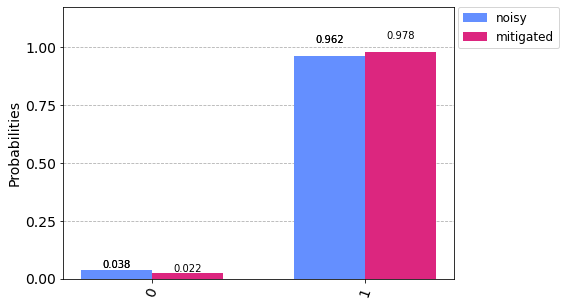

In [13]:
#Measuring the decoy photons inserted in sequence of pure entangled states in respective bases and finiding the errors

errors_for_first_check0=[]
errors_count_for_first_check0=[]
def check_eavesdropper1(pkd,rdq_st1,errors_for_first_check0,errors_count_for_first_check0,pos1):
    j=0
    m_err1=0
    err_rate1=0.0
    m_err_rate1=0.0
    err_count1=0
    err_count_rate1=0.0
    time01 = time.time()
    for i in pos1:
        flag=0
        if rdq_st1[j]=='+' or rdq_st1[j]=='-':
            pkd[i].h(0)
            flag=1
        decoy1 = find_decoy_st(rdq_st1[j],flag)
        mitigated_counts1=mitigate_error(pkd[i],decoy1,shots)
        pkd[i].measure(0,0)
        rslt1 = execute(pkd[i], backend=created_noisy_sim, shots=shots).result()
        cc1 = rslt1.get_counts()
        k=list(cc1.keys())
        k.sort()
        #display(pkd[i].draw('mpl'))
        print("The noisy measurements of the decoy photon at position",i,"after the attack is:",cc1)   
        print("The mitigated measurements of the decoy photon at position",i,"after the attack is:",mitigated_counts1)
        err1,err_count1=noisy_meas_err_func(cc1,rdq_st1,j,shots,flag)
        m_err1=mitigated_meas_err_func(mitigated_counts1,rdq_st1,j,shots,flag)
        j=j+1
        err_rate1=err_rate1+float((err1/shots)*100)
        m_err_rate1=m_err_rate1+float((m_err1/shots)*100)
    time_1 = time.time() - time01
    hr1 = time_1//3600
    time_1 %= 3600
    err_rate1=float(err_rate1/nd)
    m_err_rate1=float(m_err_rate1/nd)
    err_count_rate1=float((err_count1/nd)*100)
    errors_for_first_check0.append(err_rate1)
    errors_count_for_first_check0.append(err_count_rate1)
    return cc1,mitigated_counts1,err_count1,err_count_rate1,err_rate1,m_err_rate1,hr1,time_1

cc1,mitigated_counts1,err_count1,err_count_rate1,err_rate1,m_err_rate1,hr1,time_1=check_eavesdropper1(pkd0,rdq_st10,errors_for_first_check0,errors_count_for_first_check0,pos10)
print(f"Noisy error rate in measuring decoy photons: {err_rate1} %")
print(f"Mitigated error rate in measuring decoy photons: {m_err_rate1} %")
print(f"The number of mismatched decoy photons is {err_count1} and the error rate of trasmitting decoy photons: {err_count_rate1} %")
print(f'Time taken to measure {nd} decoy photons: {int(hr1)} hours {int(time_1//60)} minutes {time_1%60} seconds')
if err_count1!=0:
    print("\nEavesdropper detected.")
else:
    print("\nNo Eavesdropper detected.")
    
plot_histogram([cc1, mitigated_counts1], legend=['noisy', 'mitigated'])

In [14]:
#Step2:Creating a sequence of travelling qubits in Z basis

def create_tq(msg):
    tt=[]
    for i in msg:
        t=QuantumCircuit(QuantumRegister(1))
        if i==0:
            tt.append(t)
        else:
            t.x(0)
            tt.append(t)
    return tt


tq0=create_tq(message)        

In [15]:
#Step3: Encrypting the message using CNOT gate

def encrypt_mes(pk,tt,m):
    for i in range(m):       
        pk[i].add_register(*tt[i].qregs)
        pk[i].barrier()
        pk[i]=pk[i]+tt[i]
        #display(pk[i].draw('mpl'))
        pk[i].cx(0,2)
        

encrypt_mes(private_key0,tq0,n)


#inserting decoy photons in the sequence of travelling photons to check for eavesdropping
def insert_decoys2(private_key,nd):
    rdq_st2=[]
    lst=[x for x in range(n+nd)]
    pos2=sample(lst,nd)
    pos2.sort()
    rdq2=[]
    for i in pos2:
        decoy_st2=choice(states)
        decoy2=gen_decoy(decoy_st2)
        rdq2.append(decoy2)
        rdq_st2.append(decoy_st2)
        decoy22=decoy2.copy()
        private_key.insert(i,decoy22)
    print(pos2)
    return private_key,rdq_st2,pos2

private_key0,rdq_st20,pos20=insert_decoys2(private_key0,nd)

[2, 3, 7, 8, 14, 16, 18, 19, 21, 23]


<ipython-input-15-1da6b4dc2c54>:7: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  pk[i]=pk[i]+tt[i]


In [16]:
for i in range(nd):
    print(rdq_st20[i])

0
0
-
-
+
0
0
-
+
+


The measurements of the decoy photon at position 2 after the attack is: {'0': 1018, '1': 6}
The mitigated measurements of the decoy photon at position 2 after the attack is: {'0': 23, '1': 1001}
The measurements of the decoy photon at position 3 after the attack is: {'0': 1017, '1': 7}
The mitigated measurements of the decoy photon at position 3 after the attack is: {'0': 23, '1': 1001}
The measurements of the decoy photon at position 7 after the attack is: {'1': 982, '0': 42}
The mitigated measurements of the decoy photon at position 7 after the attack is: {'0': 23, '1': 1001}
The measurements of the decoy photon at position 8 after the attack is: {'1': 987, '0': 37}
The mitigated measurements of the decoy photon at position 8 after the attack is: {'0': 23, '1': 1001}
The measurements of the decoy photon at position 14 after the attack is: {'0': 1017, '1': 7}
The mitigated measurements of the decoy photon at position 14 after the attack is: {'0': 23, '1': 1001}
The measurements of the

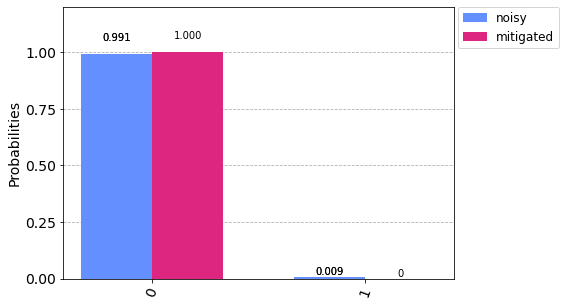

In [17]:
#Measuring the decoy photons inserted in sequence of travelling photons in respective bases and finiding the errors

errors_for_second_check0=[]
def check_eavesdropper2(pk,rdq_st2,errors_for_second_check,pos2):
    j=0
    err2=0
    m_err2=0
    err_rate2=0.0
    m_err_rate2=0.0
    err_count2=0
    err_count_rate2=0.0
    time02 = time.time()
    for i in pos2:
        flag=0
        if rdq_st2[j]=='+' or rdq_st2[j]=='-':
            pk[i].h(0)
            flag=1
        decoy2 = find_decoy_st(rdq_st2[j],flag)
        mitigated_counts2=mitigate_error(pk[i],decoy2,shots)
        pk[i].measure(0,0)
        rslt2 = execute(pk[i], backend=created_noisy_sim, shots=shots).result()
        cc2 = rslt2.get_counts()
        m=list(cc2.keys())
        m.sort()
        #display(pk[i].draw('mpl'))
        print("The measurements of the decoy photon at position",i,"after the attack is:",cc2)
        print("The mitigated measurements of the decoy photon at position",i,"after the attack is:",mitigated_counts1)
        err2,err_count2=noisy_meas_err_func(cc2,rdq_st2,j,shots,flag)
        m_err2=mitigated_meas_err_func(mitigated_counts2,rdq_st2,j,shots,flag)
        j=j+1
        err_rate2=err_rate2+float((err2/shots)*100)
        m_err_rate2=m_err_rate2+float((m_err2/shots)*100)
    time_2 = time.time() - time02
    hr2 = time_2//3600
    time_2 %= 3600
    err_rate2=float(err_rate2/nd)
    m_err_rate2=float(m_err_rate2/nd)
    err_count_rate2=float((err_count2/nd)*100)
    errors_for_second_check.append(err_rate2)
    return cc2,mitigated_counts2,err_count2,err_count_rate2,err_rate2,m_err_rate2,hr2,time_2

cc2,mitigated_counts2,err_count2,err_count_rate2,err_rate2,m_err_rate2,hr2,time_2=check_eavesdropper2(private_key0,rdq_st20,errors_for_second_check0,pos20)
print(f"Noisy error rate in measuring decoy photons: {err_rate2} %")
print(f"Mitigated error rate in measuring decoy photons: {m_err_rate2} %")
print(f"The number of mismatched decoy photons is {err_count2} and the error rate of trasmitting decoy photons: {err_count_rate2} %")
print(f'Time taken to measure {nd} decoy photons: {int(hr2)} hours {int(time_2//60)} minutes {time_2%60} seconds')
if err_count2!=0:
    print("\nEavesdropper detected.")
else:
    print("\nNo Eavesdropper detected.")
    
plot_histogram([cc2, mitigated_counts2], legend=['noisy', 'mitigated'])

In [18]:
#Step 4: Decrypting the message using CNOT gate

def decrypt_mes(pk,m,pos2):
    for i in range(m):
        if i not in pos2:
            pk[i].cx(1,2)
            pk[i].barrier()
            #display(pk[i].draw('mpl'))
        
decrypt_mes(private_key0,n+nd,pos20)

In [19]:
def cal_error_and_res(fm,mssg,j,error_in_mssg):
    error=0
    a=list(fm.keys())
    a.sort()
    res=-1
    if '0' in fm and '1' not in fm:
        res=0
    elif '1' in fm and '0' not in fm:
        res=1
    if '0' in fm and '1' in fm:
        if fm['0']>fm['1'] and abs(fm['0']-fm['1'])>600:
            res=0
        elif fm['0']<fm['1'] and abs(fm['0']-fm['1'])>600:
            res=1
        if int(a[0])==mssg[j]:
            error=fm['1']
        elif int(a[1])==mssg[j]:
            error=fm['0']
    if res!=mssg[j]:
        error_in_mssg+=1
    return res,error

Noisy counts are: {'1': 959, '0': 65}
Mitigated counts are: {'0': 0, '1': 1024}
Noisy counts are: {'1': 961, '0': 63}
Mitigated counts are: {'0': 4, '1': 1020}
Noisy counts are: {'1': 968, '0': 56}
Mitigated counts are: {'0': 38, '1': 986}
Noisy counts are: {'0': 1008, '1': 16}
Mitigated counts are: {'0': 1024, '1': 0}
Noisy counts are: {'1': 976, '0': 48}
Mitigated counts are: {'0': 30, '1': 994}
Noisy counts are: {'1': 978, '0': 46}
Mitigated counts are: {'0': 6, '1': 1018}
Noisy counts are: {'0': 1012, '1': 12}
Mitigated counts are: {'0': 1022, '1': 2}
Noisy counts are: {'0': 1006, '1': 18}
Mitigated counts are: {'0': 1024, '1': 0}
Noisy counts are: {'1': 962, '0': 62}
Mitigated counts are: {'0': 8, '1': 1016}
Noisy counts are: {'1': 961, '0': 63}
Mitigated counts are: {'0': 30, '1': 994}
Noisy counts are: {'1': 968, '0': 56}
Mitigated counts are: {'0': 0, '1': 1024}
Noisy counts are: {'1': 969, '0': 55}
Mitigated counts are: {'0': 28, '1': 996}
Noisy counts are: {'1': 959, '0': 65}

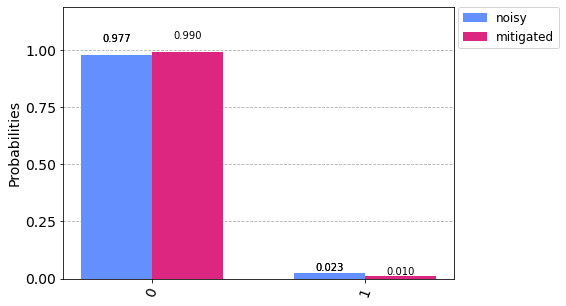

In [20]:
#Measuring the travelling qubit in Z basis

error_lst=[]
errors_in_mssg=[]
m_error_lst=[]
def measure_tq(pk,error_lst,errors_in_mssg,mssg,pos2):
    error=m_error=0
    error_rate=m_error_rate=0.0
    error_in_mssg=m_error_in_mssg=0
    error_in_mssg_rate=m_error_in_mssg_rate=0.0
    result2=[]
    m_result2=[]
    time03 = time.time()
    j=0
    for i in range(n+nd):
        if i not in pos2:
            mitigated_counts=mitigate_error(pk[i],mssg[j],shots)
            pk[i].measure(2,0)
            result = execute(pk[i], backend=created_noisy_sim, shots=shots).result()
            noisy_counts=result.get_counts()
            print("Noisy counts are:",noisy_counts)
            print("Mitigated counts are:",mitigated_counts)        
            res,error=cal_error_and_res(noisy_counts,mssg,j,error_in_mssg)
            m_res,m_error=cal_error_and_res(mitigated_counts,mssg,j,error_in_mssg)
            error_rate = error_rate + float((error/shots)*100)
            m_error_rate = m_error_rate + float((m_error/shots)*100)
            result2.append(res)
            m_result2.append(m_res)
            #display(private_key[i].draw('mpl'))
            j+=1
    time_3 = time.time() - time03
    hr3 = time_3//3600
    time_3 %= 3600
    error_in_mssg_rate=float((error_in_mssg/n)*100)
    error_rate = float(error_rate/n)
    error_lst.append(error_rate)
    errors_in_mssg.append(error_in_mssg_rate)
    m_error_rate = float(m_error_rate/n)
    m_error_lst.append(m_error_rate)
    print(f"Amount of message bits received incorrectly: {error_in_mssg_rate} %")
    print(f"Error rate in measuring message photons: {error_rate} %")
    print(f"Error rate in measuring message photons after error mitigation: {m_error_rate} %")
    print(f'Time taken to measure {n} travelling photons: {int(hr3)} hours {int(time_3//60)} minutes {time_3%60} seconds')
    return result2,noisy_counts,mitigated_counts

final_res,noisy_counts,mitigated_counts=measure_tq(private_key0,error_lst,errors_in_mssg,message,pos20)     
plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])
